In [140]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch
import math

from dataset import TranslationDataset, tokenize_data, prepare_datasets
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [55]:
batch_size = 16
max_seq_length = 300
epochs = 3

In [56]:
print(f"Number of CPU cores: {os.cpu_count()}")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Number of CPU cores: 11


In [57]:
with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/English_Text.txt', "r") as english_file_te_trans:
    source_eng_to_te_text = english_file_te_trans.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-te/Telugu_Text.txt', "r") as telugu_file:
    telugu_text = telugu_file.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-hi/english_text.txt',"r") as english_file_hi_trans:
    source_eng_to_hi_text = english_file_hi_trans.readlines()

with open('/Users/venu/Documents/Productivity/Pytorch Tutorials/en-hi/hindi_text.txt', "r") as hindi_file:
    hindi_text = hindi_file.readlines()

In [58]:
len(source_eng_to_te_text), len(telugu_text), len(source_eng_to_hi_text), len(hindi_text)

(4946036, 4946036, 8568307, 8568307)

In [59]:
SAMPLE_NUM = 20000

In [60]:
source_eng_tel_trans = source_eng_to_te_text[-SAMPLE_NUM:]
target_telugu = telugu_text[-SAMPLE_NUM:]
source_eng_hin_trans = source_eng_to_hi_text[:SAMPLE_NUM]
target_hindi = hindi_text[:SAMPLE_NUM]

In [61]:
# stripping new line
source_english_te_sentences = [sentence.rstrip('\n') for sentence in source_eng_tel_trans]
telugu_sentences = [sentence.rstrip('\n') for sentence in target_telugu]

In [62]:
source_english_hi_sentences = [sentence.rstrip('\n') for sentence in source_eng_hin_trans]
hindi_sentences = [sentence.rstrip('\n') for sentence in target_hindi]

In [63]:
# checking max lenght of english and telugu sentences
max_english_te_sentence_lenght = max(len(sentence) for sentence in source_english_te_sentences)
max_telugu_sentence_length = max(len(sentence) for sentence in telugu_sentences)
max_english_hi_sentence_lenght = max(len(sentence) for sentence in source_english_hi_sentences)
max_hini_sentence_length = max(len(sentence) for sentence in hindi_sentences)
max_english_te_sentence_lenght, max_telugu_sentence_length, max_english_hi_sentence_lenght, max_hini_sentence_length

(912, 817, 1098, 1171)

In [64]:
# restricting the max length sentences to be allowed to 97 percentile
# Calculate sentence lengths
en_te_sentence_lengths = [len(sentence) for sentence in source_english_te_sentences]
te_sentence_lengths = [len(sentence) for sentence in telugu_sentences]

# Calculate desired percentile
percentile = 97
en_te_value = np.percentile(en_te_sentence_lengths, percentile)
te_value = np.percentile(te_sentence_lengths, percentile)

print(f"English sentences under {percentile}th percentile: {en_te_value}")
print(f"Telugu sentences under {percentile}th percentile: {te_value}")

English sentences under 97th percentile: 172.02999999999884
Telugu sentences under 97th percentile: 165.0


In [65]:
en_hi_sentence_lengths = [len(sentence) for sentence in source_english_hi_sentences]
hi_sentence_lengths = [len(sentence) for sentence in hindi_sentences]

# Calculate desired percentile
percentile = 97
en_hi_value = np.percentile(en_hi_sentence_lengths, percentile)
hi_value = np.percentile(te_sentence_lengths, percentile)

print(f"English sentences under {percentile}th percentile: {en_hi_value}")
print(f"Hindi sentences under {percentile}th percentile: {hi_value}")

English sentences under 97th percentile: 265.0
Hindi sentences under 97th percentile: 165.0


In [66]:
# lets format the data in mBart accepted format
ENGLISH_LANG_CODE = "[en_XX]"
TELUGU_LANG_CODE = "[te_IN]"
HINDI_LANG_CODE = "[hi_IN]"
EOS_CODE = "[eos]"

In [67]:
source_eng_tel_trans = [f"{ENGLISH_LANG_CODE}{sentence}{EOS_CODE}" for sentence in source_english_te_sentences]
target_telugu_trans = [f"{TELUGU_LANG_CODE}{sentence}{EOS_CODE}" for sentence in telugu_sentences]
source_eng_hi_trans = [f"{ENGLISH_LANG_CODE}{sentence}{EOS_CODE}" for sentence in source_english_hi_sentences]
target_hindi_trans = [f"{HINDI_LANG_CODE}{sentence}{EOS_CODE}" for sentence in hindi_sentences]

In [68]:
source_eng_tel_trans[100], target_telugu_trans[100], source_eng_hi_trans[100], target_hindi_trans[100]

('[en_XX]I hope Hemant Soren and his government will work to fulfil the dreams of the people: Raghubar Das after tendering his resignation as Jharkhand CM [eos]',
 '[te_IN]జార్ఖండ్ ఎన్నికల్లో ప్రజాతీర్పును శిరసావహిస్తున్నా, హేమంత్ సోరెన్ నేతృత్వంలోని కొత్త ప్రభుత్వం ప్రజల కలలను నేరవేరుస్తుందని ఆశిస్తున్నా: ఆపదర్మ సీఎం రఘుబర్ దాస్ [eos]',
 '[en_XX]but those who disbelieve in the Everlasting Life deviate from the Path.[eos]',
 '[hi_IN]किन्तु जो लोग आख़िरत पर ईमान नहीं रखते वे इस मार्ग से हटकर चलना चाहते है[eos]')

In [69]:
len(source_eng_tel_trans), len(target_telugu_trans), len(source_eng_hi_trans), len(target_hindi_trans)

(20000, 20000, 20000, 20000)

In [70]:
combined_source = source_eng_tel_trans + source_eng_hi_trans
combined_target = target_telugu_trans + target_hindi_trans

In [71]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation
train_src, test_val_src, train_tgt, test_val_tgt = train_test_split(
    combined_source, combined_target, test_size = 0.2, random_state = 99
)

In [72]:
# split the validation data into test and validation data
val_src, test_src, val_tgt, test_tgt = train_test_split(
    test_val_src, test_val_tgt, test_size = 0.5, random_state=99
)

In [73]:
len(train_src), len(train_tgt)

(32000, 32000)

In [74]:
len(val_src), len(val_tgt), len(test_src), len(test_tgt)

(4000, 4000, 4000, 4000)

In [75]:
!pip install transformers sentencepiece torch

In [76]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

In [77]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

### Lets create some basic visualizations around the sentences

In [141]:
def tokenize_words(sentences):
    return [word for sentence in sentences for word in sentence.split()]

In [145]:
# Vocabulary Size Comparison
def vocabulary_size(sentences):
    return len(set(tokenize_words(sentences)))

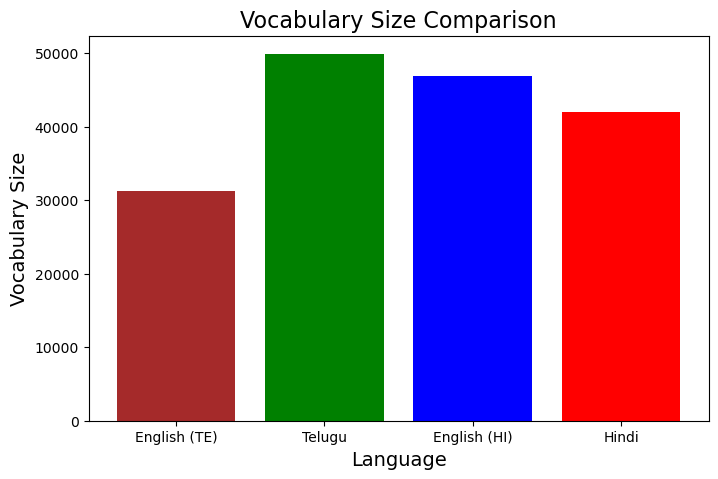

In [148]:
english_te_vocab_size = vocabulary_size(source_english_te_sentences)
telugu_vocab_size = vocabulary_size(telugu_sentences)
english_hi_vocab_size = vocabulary_size(source_english_hi_sentences)
hindi_vocab_size = vocabulary_size(hindi_sentences)

# Bar Graph
languages = ["English (TE)", "Telugu", "English (HI)", "Hindi"]
vocab_sizes = [english_te_vocab_size, telugu_vocab_size, english_hi_vocab_size, hindi_vocab_size]

plt.figure(figsize=(8, 5))
plt.bar(languages, vocab_sizes, color=["brown", "green", "blue", "red"])
plt.title("Vocabulary Size Comparison", fontsize=16)
plt.ylabel("Vocabulary Size", fontsize=14)
plt.xlabel("Language", fontsize=14)
plt.show()

In [78]:
tokenizer.src_lang = "en_XX"

train_dataset, val_dataset, test_dataset = prepare_datasets(
    train_src, 
    train_tgt, 
    val_src, 
    val_tgt, 
    test_src, 
    test_tgt, 
    tokenizer, 
    device, 
    batch_size=batch_size
)

/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_encodings = {key: torch.tensor(val).to(device) for key, val in train_encodings.items()}
/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_encodings = {key: torch.tensor(val).to(device) for key, val in val_encodings.items()}
/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/dataset.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

In [79]:
# Move model to CPU
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [80]:
print(model.config)

MBartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/mbart-large-50-many-to-many-mmt",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABE

In [81]:
!pip install tf-keras

In [82]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/mbart50_translation_results_en_te_hi',  # Output directory
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=5e-5,  # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    weight_decay=0.01,  # Weight decay
    save_total_limit=3,  # Limit the number of saved models
    num_train_epochs=epochs,  # Number of training epochs
    predict_with_generate=True,  # Enable text generation during evaluation
    logging_dir="/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/logs_en_te_hi",  # Log directory
    logging_steps=200,  # Log every 200 steps
    save_strategy="epoch",  # Save the model every epoch
    gradient_accumulation_steps=2,  # For effective batch size
    report_to="none",  # No logging to WandB or MLflow
    fp16=torch.cuda.is_available() if torch.cuda.is_available else False,  # Enable mixed precision if using GPU
    no_cuda=True,
    dataloader_num_workers=11,
    dataloader_pin_memory=False,
    load_best_model_at_end=True,  # Load best model at the end based on eval loss
    metric_for_best_model="bleu",  # Choose BLEU as the metric for best model selection
    greater_is_better=True         # Higher BLEU means better model
)

In [83]:
print(training_args)

Seq2SeqTrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=11,
dataloader_persistent_workers=False,
dataloader_pin_memory=False,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPO

In [84]:
!pip install --upgrade datasets evaluate

In [85]:
from evaluate import load

In [86]:
# Load BLEU metric from Hugging Face datasets
bleu_metric = load("sacrebleu")

In [87]:
# Function to compute perplexity and BLEU score
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # SacreBLEU expects reference as a list of list of strings
    decoded_labels = [[label] for label in decoded_labels]

    # Compute BLEU score
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Compute perplexity
    perplexity = math.exp(bleu['score'] / 100) if bleu['score'] > 0 else float('inf')

    return {
        "bleu": bleu["score"],
        "perplexity": perplexity,
    }

In [88]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Training dataset
    eval_dataset=val_dataset,      # Validation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add metrics evaluation
)
print("Model Loaded Succesfully!")

Model Loaded Succesfully!


/var/folders/yb/r3k6h0y11431_5th45hwjmjr0000gn/T/ipykernel_42482/200296214.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [89]:
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'loss': 1.3037, 'grad_norm': 0.8977478742599487, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 0.342, 'grad_norm': 1.0370839834213257, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 0.3227, 'grad_norm': 0.833600640296936, 'learning_rate': 4e-05, 'epoch': 0.6}
{'loss': 0.3172, 'grad_norm': 1.1105087995529175, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}
{'loss': 0.305, 'grad_norm': 1.000217080116272, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/250 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.286568284034729, 'eval_bleu': 25.77738046047442, 'eval_perplexity': 1.2940460782530743, 'eval_runtime': 6231.6074, 'eval_samples_per_second': 0.642, 'eval_steps_per_second': 0.04, 'epoch': 1.0}


/opt/anaconda3/lib/python3.12/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'loss': 0.2432, 'grad_norm': 0.8014422655105591, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 0.2418, 'grad_norm': 0.9177248477935791, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}
{'loss': 0.2358, 'grad_norm': 0.7996326684951782, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}
{'loss': 0.2337, 'grad_norm': 0.8494014739990234, 'learning_rate': 2e-05, 'epoch': 1.8}
{'loss': 0.2346, 'grad_norm': 1.1239866018295288, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/250 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.2715888023376465, 'eval_bleu': 26.681247963637063, 'eval_perplexity': 1.3057955601125377, 'eval_runtime': 5886.101, 'eval_samples_per_second': 0.68, 'eval_steps_per_second': 0.042, 'epoch': 2.0}
{'loss': 0.1913, 'grad_norm': 0.7450898289680481, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.2}
{'loss': 0.195, 'grad_norm': 0.7773489356040955, 'learning_rate': 1e-05, 'epoch': 2.4}
{'loss': 0.1867, 'grad_norm': 0.8704469203948975, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.6}
{'loss': 0.1918, 'grad_norm': 0.821489691734314, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}
{'loss': 0.1868, 'grad_norm': 0.8443961143493652, 'learning_rate': 0.0, 'epoch': 3.0}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


  0%|          | 0/250 [00:00<?, ?it/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.272568017244339, 'eval_bleu': 26.601175258029063, 'eval_perplexity': 1.3047503927805706, 'eval_runtime': 6052.2673, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.041, 'epoch': 3.0}


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 172072.416, 'train_samples_per_second': 0.558, 'train_steps_per_second': 0.017, 'train_loss': 0.31542002614339193, 'epoch': 3.0}


TrainOutput(global_step=3000, training_loss=0.31542002614339193, metrics={'train_runtime': 172072.416, 'train_samples_per_second': 0.558, 'train_steps_per_second': 0.017, 'total_flos': 4.06336831488e+16, 'train_loss': 0.31542002614339193, 'epoch': 3.0})

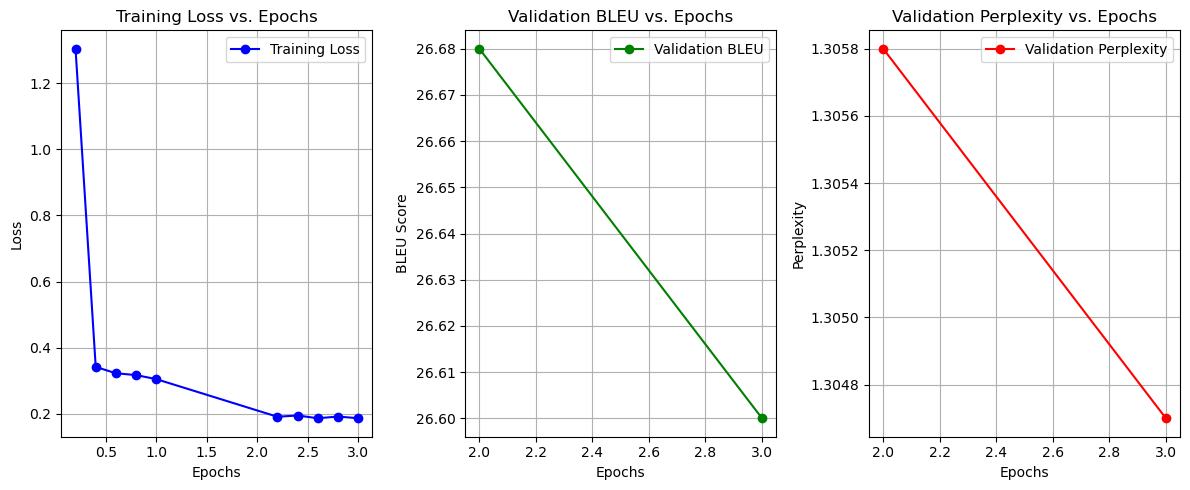

In [91]:
import matplotlib.pyplot as plt

# Training metrics
epochs = [0.2, 0.4, 0.6, 0.8, 1.0, 2.2, 2.4, 2.6, 2.8, 3.0]
training_loss = [1.3037, 0.342, 0.3227, 0.3172, 0.305, 0.1913, 0.195, 0.1867, 0.1918, 0.1868]

# Validation metrics
val_epochs = [2.0, 3.0]
val_loss = [0.2716, 0.2725]
val_bleu = [26.68, 26.60]
val_perplexity = [1.3058, 1.3047]

# Plot Training Loss
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, training_loss, marker="o", label="Training Loss", color="b")
plt.title("Training Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Validation BLEU
plt.subplot(1, 3, 2)
plt.plot(val_epochs, val_bleu, marker="o", label="Validation BLEU", color="g")
plt.title("Validation BLEU vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.legend()

# Validation Perplexity
plt.subplot(1, 3, 3)
plt.plot(val_epochs, val_perplexity, marker="o", label="Validation Perplexity", color="r")
plt.title("Validation Perplexity vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
# Define the save path
save_directory = '/Users/venu/Documents/Productivity/Pytorch Tutorials/Attention is All You Need Paper Replication/mbart50_translation_en_te_hi_model_lit'

# Save the fine-tuned model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [93]:
# Load the model and tokenizer
model = MBartForConditionalGeneration.from_pretrained(save_directory)
tokenizer = MBart50TokenizerFast.from_pretrained(save_directory)

# Move to device (use CPU if no GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded successfully for inference!")

Model loaded successfully for inference!


In [122]:
def translate_text(input_text, src_lang="en_XX", tgt_lang="te_IN", max_length=200):
    tokenizer.src_lang = src_lang
    model.eval()  # Set model to evaluation mode

    # Prepare input text with language tokens
    formatted_input = f"{src_lang} {input_text}"

    # Tokenize and move input to the correct device
    inputs = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Generate translation
    with torch.no_grad():
        generated_ids = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])

    translated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return translated_text

In [123]:
user_input = "Hello World!! I am a language translator capable of translating sentences from English to Telugu and Hindi."
translation = translate_text(user_input)
print(f"Telugu Translation: {translation}")

Telugu Translation: హలో విల్ట్ ! ఇంగ్లీష్ నుండి తెలుగు, హిందీ భాషలకు జవాబులను అనువదిరించగల నైపుణ్యం ఉన్న ఒక భాష ట్రాన్సాటర్.


In [126]:
def translate_user_input(input_text, target_lang_code):
    tokenizer.src_lang = "en_XX"
    model_inputs = tokenizer(f"en_XX{input_text}{EOS_CODE}", return_tensors="pt").to(device)
    
    # Force BOS token to the target language
    forced_bos_token_id = tokenizer.lang_code_to_id[target_lang_code]
    
    outputs = model.generate(
        **model_inputs,
        forced_bos_token_id=forced_bos_token_id,
        max_length=200,
        num_beams=5  # Optional: Improve diversity in generated translations
    )
    print(outputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

In [139]:
# Example Inference
english_sentence = "Cool. Lets do some crazy stuff today and enjoy the day."
telugu_translation = translate_user_input(english_sentence, "te_IN")
hindi_translation = translate_user_input(english_sentence, "hi_IN")

print("Telugu Translation:", telugu_translation)
print("Hindi Translation:", hindi_translation)

Telugu Translation: కూల్. నేడు కొన్ని వెర్రి మాయలు చేసుకుందాం మరియు రోజు ఆనందించండి. [eos]
Hindi Translation: कूल. चलो आज कुछ पागल काम करते हैं और दिन का आनंद उठाते हैं।[eos]


In [118]:
print(tokenizer.all_special_tokens)

['<s>', '</s>', '<unk>', '<pad>', '<mask>', 'ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']


In [119]:
print(tokenizer.special_tokens_map)


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']}


In [129]:
tokenizer.eos_token_id

2